### <center> **Bayesian Differential Equations**
#### <center> **Turing.jl**

In [ ]:
include("C:/Users/mussi/Documents/Manhattan/Leuven/MCQMC/Data_Libraries/1.Libraries_setup.jl")

using MCMCChains
using FFTW
using Turing;
using AdvancedMH
using AbstractMCMC

  Activating project at `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries`
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (4))


In [5]:
Threads.nthreads()

1

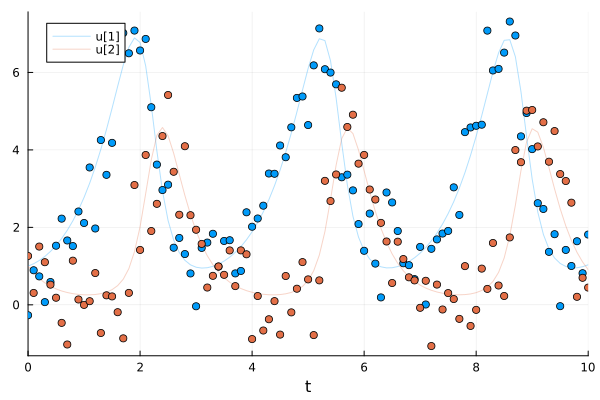

In [2]:
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)
sol = solve(prob, Tsit5(); saveat=0.1)
dt_noisy = Array(sol) + 0.8 * randn(size(Array(sol)))

# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(sol.t, dt_noisy'; color=[1 2], label="")

#### <center> **Metropolis-Hastings**

In [ ]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1, abstol=1e-6, reltol=1e-6)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(dt_noisy, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
# No-U-Turn Sampler (NUTS) with 1000 samples per chain. 
# MCMCSerial() to run chains in serial.
# MCMCThreads() to run chains in parallel.
# MCMCDistributed() to run chains in distributed processes.

MH_chain = sample(model, MH(), MCMCSerial(), 1000, 3; progress=false)

Chains MCMC chain (1000×8×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 0.91 seconds
Compute duration  = 0.88 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [29]:
describe(MH_chain)

Chains MCMC chain (1000×8×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 0.91 seconds
Compute duration  = 0.88 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

           σ    0.9956    0.3394    0.0813    10.7619     7.2778    1.4075       12.2294
           α    1.4312    0.1006    0.0247    14.0623    14.9800    1.3669       15.9799
           β    1.0904    0.2261    0.0596    22.8896    16.7880    1.2260       26.0109
           γ    3.1371    0.2962    0.0936    10.4361     7.5516    1.5399       11.8592
           δ    1.1453    0.1331    0.0319    17.1093    12.4617    1.2379       19.4424

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      

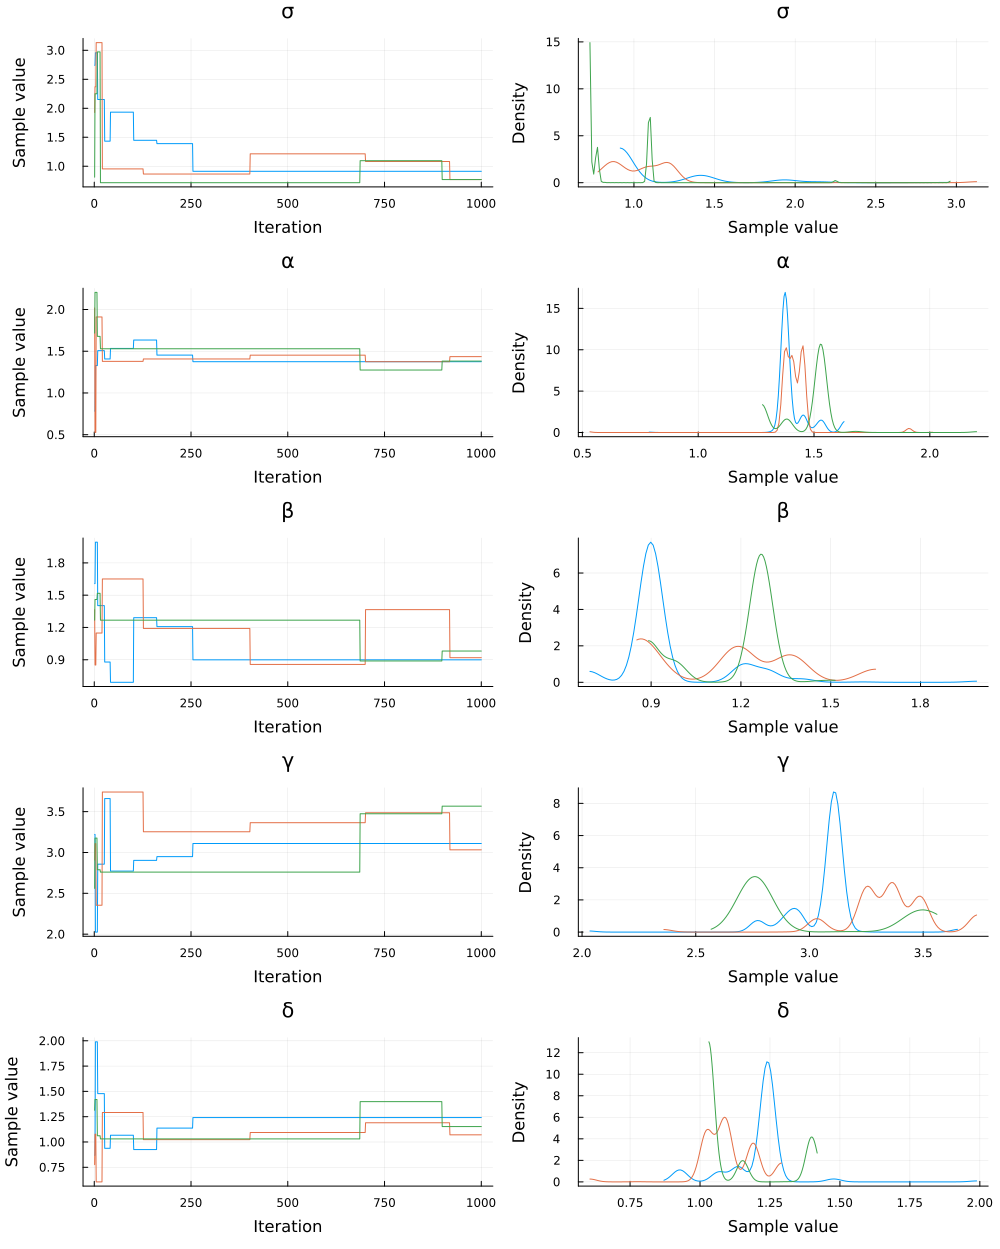

In [30]:
plot(MH_chain, left_margin = 5mm)

#### <center> **Robust Adaptive Metropolis-Hastings (RAM)**  
https://turinglang.org/AdvancedMH.jl/stable/api/

#### <center> **External Sampler: Metropolis Adjusted Langevin Algorithm (Mala)**

Turing.jl includes wrapped samplers—pre-integrated versions of external algorithms (like HMC and NUTS from AdvancedHMC.jl) that let users sample models easily without extra setup.
However, these wrappers expose only part of the functionality available in the underlying libraries.   
To access more advanced or currently unwrapped samplers (e.g., MALA, MMALA, RMHMC), Turing allows direct use of external samplers through externalsampler(...), so models can be sampled by any compatible algorithm without modifying the model definition.   
https://turinglang.org/docs/tutorials/docs-17-implementing-samplers/

#### <center> **Hamiltonian Monte Carlo**

In [ ]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1, abstol=1e-6, reltol=1e-6)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(dt_noisy, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
# No-U-Turn Sampler (NUTS) with 1000 samples per chain. 
# MCMCSerial() to run chains in serial.
# MCMCThreads() to run chains in parallel.
# MCMCDistributed() to run chains in distributed processes.

chain = sample(model, NUTS(), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\mussi\.julia\packages\Turing\nZgyL\src\mcmc\hmc.jl:216
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\mussi\.julia\packages\Turing\nZgyL\src\mcmc\hmc.jl:216
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\mussi\.julia\packages\Turing\nZgyL\src\mcmc\hmc.jl:216


Chains MCMC chain (1000×19×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 49.55 seconds
Compute duration  = 49.49 seconds
parameters        = σ, α, β, γ, δ
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [22]:
describe(chain)

Chains MCMC chain (1000×19×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 49.55 seconds
Compute duration  = 49.49 seconds
parameters        = σ, α, β, γ, δ
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64       Float64 

           σ    0.7802    0.0401    0.0010   1785.5717   1495.0472    1.0027       36.0780
           α    1.5006    0.0485    0.0017    832.1167   1001.7904    1.0002       16.8132
           β    1.0233    0.0459    0.0014   1136.3122   1382.3551    1.0007       22.9595
           γ    2.9942    0.1394    0.0048    857.9207   1121.2

In [ ]:
# Maximum likelihood estimation
mle_estimate = maximum_likelihood(model)

ModeResult with maximized lp of -232.40
[0.7645815372285996, 1.499405606785705, 1.0173563819844071, 2.990468875544877, 1.0038616149895367]

In [ ]:
# Maximum a posteriori estimation
map_estimate = maximum_a_posteriori(model)

ModeResult with maximized lp of -234.11
[0.7663204349800823, 1.5003411371336985, 1.0187177315324756, 2.9881300386753162, 1.0028996423359229]

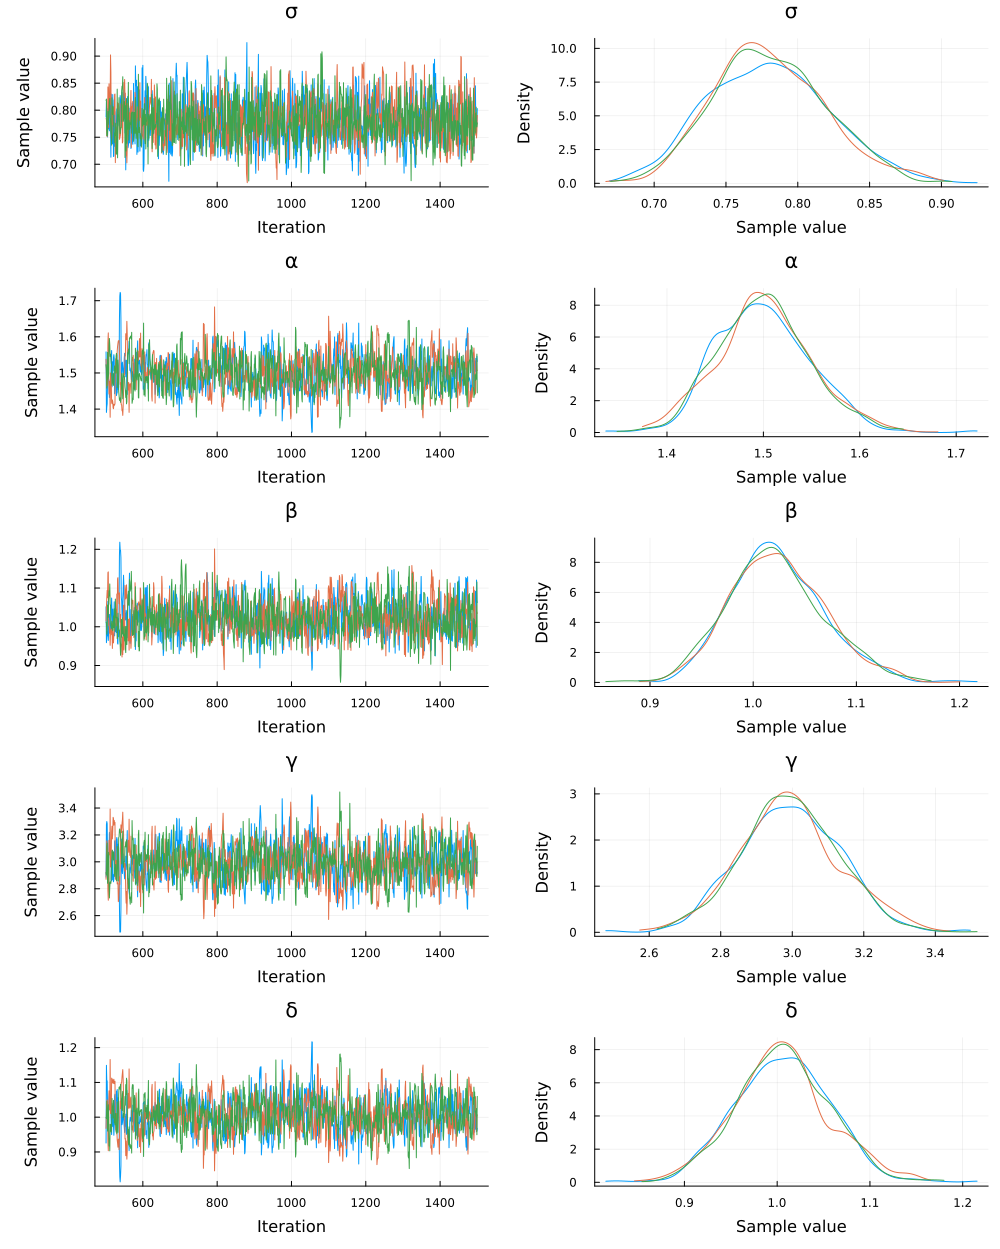

In [23]:
plot(chain, left_margin = 8mm)

Here, we solve the ODE for 300 randomly picked posterior samples in the chain. We plot the ensemble of solutions to check if the solution resembles the data. The 300 retrodicted time courses from the posterior are plotted in gray, the noisy observations are shown as blue and red dots, and the green and purple lines are the ODE solution that was used to generate the data.



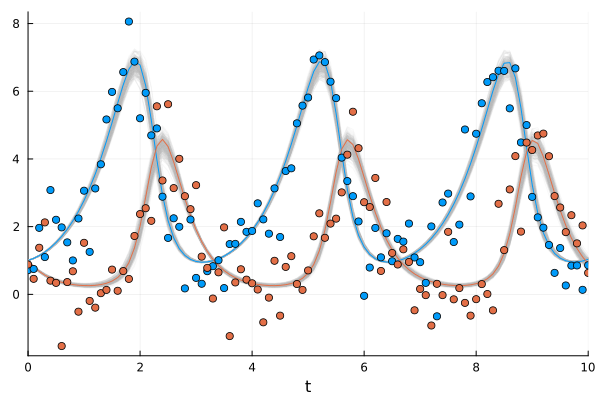

In [15]:
plot(; legend=false)
posterior_samples = sample(chain[[:α, :β, :γ, :δ]], 300; replace=false)
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob, Tsit5(); p=p, saveat=0.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol; color=[1 2], linewidth=1)
scatter!(sol.t, odedata'; color=[1 2])